In [5]:
# --- LIBRERIAS ---
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

In [6]:
# --- CONFIGURACIONES MODIFICABLES ---

# 1. RUTA A LOS DATOS
# Busca todos los archivos que terminen en '*_formatted.csv' en la carpeta 
# especificada y los almacena en una lista
data_path = 'data/processed/piezometers/formatted/'
piezometer_files = glob.glob(os.path.join(data_path, '*_formatted.csv'))

# Imprime los archivos encontrados
print(f'Archivos con datos piezometricos encontrados: {len(piezometer_files)}')
print(piezometer_files)

# 2. CAMPANAS DE TERRENO
# Define un diccionario con el nombre y rango de fechas de cada campana.
# La fecha de termino es excluyente. Se consideran fechas de trabajo efectivo.
field_campaigns = {
    "May 2024": pd.date_range(start='2024-05-21', end='2024-05-23'),
    "Jul 2024": pd.date_range(start='2024-07-25', end='2024-07-28'),
    "Sep 2024": pd.date_range(start='2024-09-03', end='2024-09-07'),
    "Nov 2024": pd.date_range(start='2024-11-05', end='2024-11-12'),
    "Jan 2025": pd.date_range(start='2025-01-21', end='2025-01-23'),
    "Apr 2025": pd.date_range(start='2025-04-28', end='2025-05-02'),
    "Jul 2025": pd.date_range(start='2025-07-08', end='2025-07-16')
}

# 3. MAYOR INTERVALO DE MEDICION DE LOS DATALOGGERS
max_expected_interval='15min'

Archivos con datos piezometricos encontrados: 6
['data/processed/piezometers/formatted\\SDH1PS01_formatted.csv', 'data/processed/piezometers/formatted\\SDH1PS02_formatted.csv', 'data/processed/piezometers/formatted\\SDH2PP01_formatted.csv', 'data/processed/piezometers/formatted\\SDH2PS01_formatted.csv', 'data/processed/piezometers/formatted\\SDH2PS02_formatted.csv', 'data/processed/piezometers/formatted\\SDH2PS03_formatted.csv']


In [7]:
# --- DEFINICION DE FUNCIONES ---

# 1. IDENTIFICACION DE DATOS DUPLICADOS

def check_duplicates(df):
    """Revisa e informa sobre datos duplicados en el indice"""

    # Genera una serie booleana que almacena los indices duplicados como True
    duplicates = df.index.duplicated(keep=False)

    # Comprueba si la serie duplicates tiene algun valor True
    if not duplicates.any():
        print('\nNo hay datos duplicados')
    # De haberlos, imprime el total y a cuales registros corresponde
    else:
        print(f'\nHay {duplicates.sum()} datos duplicados:')
        print(df[duplicates])


# 2. IDENTIFICACION DE SALTOS REGULARES Y ANOMALOS EN LOS DATOS

def check_discontinuities(df, max_expected_interval):
    """Revisa e informa sobre saltos de tiempo en el indice"""
    
    # Genera una serie Timedelta que almcacena el tiempo transcurrido desde el registro anterior
    intervals = df.index.to_series().diff()

    # Genera una nueva serie con los Timedelta que superan un intervalo maximo esperado
    interval_anomalies = intervals[intervals > pd.Timedelta(max_expected_interval)]

    # Imprime los intervalos mas comunes y su frecuencia
    print(f'\nConteo de intervalos:\n{intervals.value_counts().head()}')

    # Comprueba si la serie interval_anomalies tiene algun valor
    if interval_anomalies.empty:
        print(f'\nNo hay intervalos anomalos')
    # De ser asi, imprime los registros con intervalos anomalos
    else:
        print(f'\nIntervalos anomalos:\n{interval_anomalies}')


# 3. IDENTIFICACION DE DATOS ANOMALOS DURANTE CAMPANAS DE TERRENO

def check_outliers(df, campaign_dates, well_name, campaign_name):
    """Identifica, informa y visualiza outliers en un rango de fechas"""

    # Hace una copia del df y lo filtra a las fechas de la campana de terreno
    df_copy = df.copy()
    df_campaign = df_copy.loc[campaign_dates.min() : campaign_dates.max()- pd.Timedelta(seconds=1)].copy()

    # Si no hay datos durante la campana se detiene la funcion
    if df_campaign.empty:
        print("No se encontraron datos para esta campana")
        return

    # Calcula el z-score de los valores de Temperature_C y Depth_m durante la campana
    df_campaign['z_temp'] = stats.zscore(df_campaign['Temperature_C'])
    df_campaign['z_depth'] = stats.zscore(df_campaign['Depth_m'])

    # Crea un df con registros que tengan z-scores > 3
    outlier_condition = (abs(df_campaign['z_temp']) > 3) | (abs(df_campaign['z_depth']) > 3)
    df_outliers = df_campaign[outlier_condition]

    # Comprueba si el df_outliers tiene algun valor anomalo
    if not df_outliers.empty:
        print("\nOutliers detectados:")
        print(df_outliers[['Temperature_C', 'Depth_m', 'z_temp', 'z_depth']])
    else:
        print("\nNo se encontraron valores con z-Score > 3 en esta campana.")

    # Grafica los valores normalizados de Temperature_C y Depth_m
    title = f"{well_name} - {campaign_name}"
    ax = df_campaign[['z_temp', 'z_depth']].plot(
        figsize=(10, 4),
        title=title,
        grid=True
    )
    ax.axhline(3, color='r', linestyle='--', lw=0.8)
    ax.axhline(-3, color='r', linestyle='--', lw=0.8)
    ax.set_ylabel('Z-Score')
    ax.set_xlabel('')
    plt.show()


POZO: SDH1PS01
Archivo: SDH1PS01_formatted.csv

Rango de fechas: 2024-05-23 00:00:00 - 2025-07-15 10:10:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35535
0 days 00:05:00    18344
0 days 00:15:00    10346
0 days 00:40:00        2
0 days 01:40:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2024-07-25 18:20:00   0 days 01:40:00
2024-09-05 14:00:00   0 days 00:40:00
2024-11-10 15:00:00   0 days 01:30:00
2025-01-22 14:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2024-07-25 18:20:00          8.767   0.5355  10.309266 -0.237084
2024-07-25 18:35:00          8.002   0.5352   7

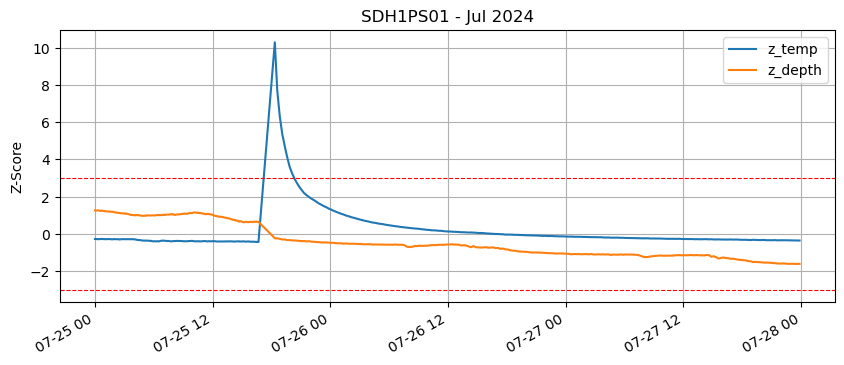


Diagnostico campana de Sep 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-09-05 14:00:00          5.560   0.1712  9.306169 -1.940073
2024-09-05 14:15:00          5.444   0.1735  5.706213 -1.760613
2024-09-05 14:30:00          5.389   0.1741  3.999337 -1.713797
2024-09-05 14:45:00          5.358   0.1737  3.037280 -1.745007


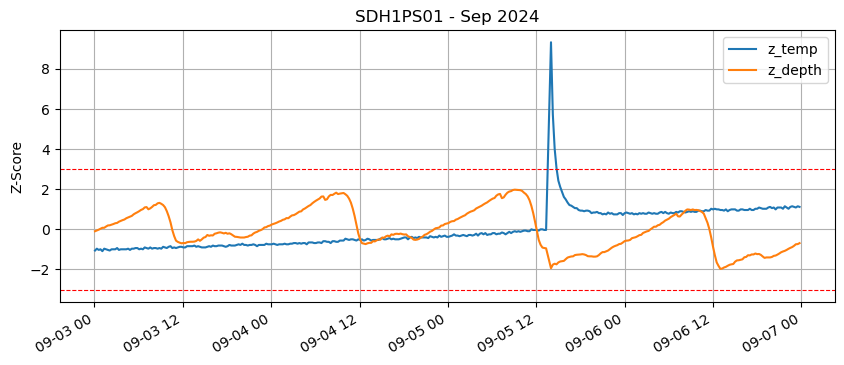


Diagnostico campana de Nov 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-10 15:00:00          6.464   0.5266  7.834541  0.097108
2024-11-10 15:10:00          6.353   0.5278  5.062561  0.258605
2024-11-10 15:20:00          6.299   0.5280  3.714030  0.285521


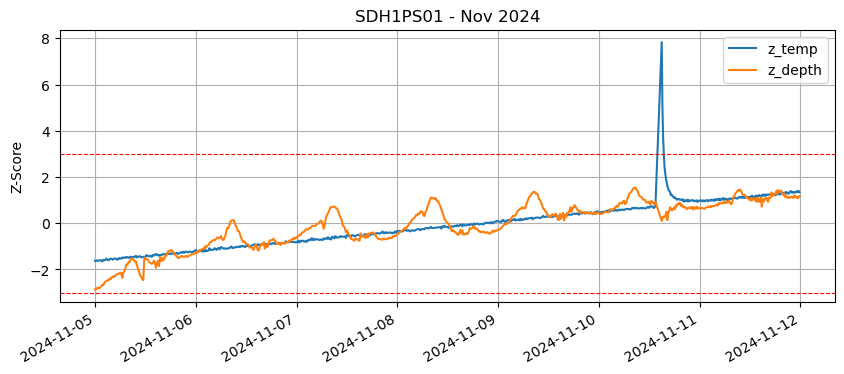


Diagnostico campana de Jan 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 14:00:00          9.608   0.5726  7.984293  1.102741
2025-01-22 14:10:00          9.529   0.5721  5.558329  0.784900
2025-01-22 14:20:00          9.484   0.5715  4.176451  0.403491
2025-01-22 14:30:00          9.455   0.5724  3.285907  0.975604


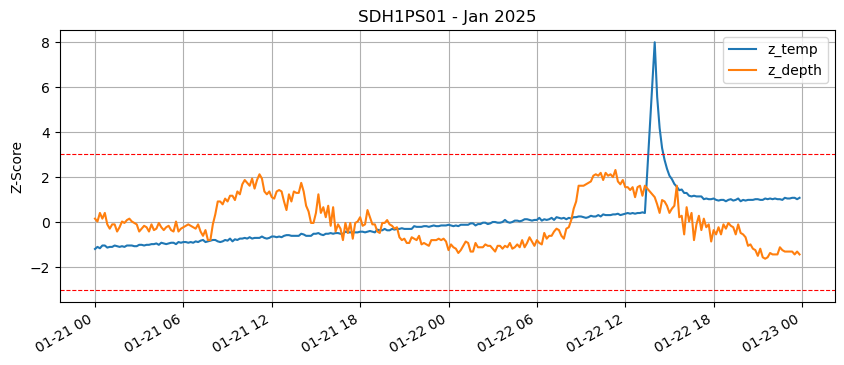


Diagnostico campana de Apr 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp    z_depth
Timestamps                                                       
2025-04-30 17:20:00          9.449   1.2098  -1.592473  10.705838
2025-05-01 10:30:00         10.054   1.2009   0.092288  10.554248
2025-05-01 10:40:00         13.962   1.1965  10.975008  10.479304
2025-05-01 10:50:00         16.385   1.1960  17.722405  10.470788
2025-05-01 11:00:00         13.475   1.1945   9.618845  10.445239


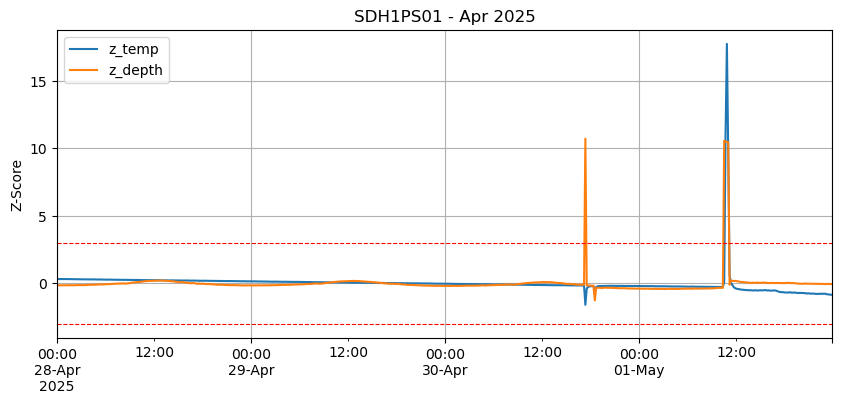


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


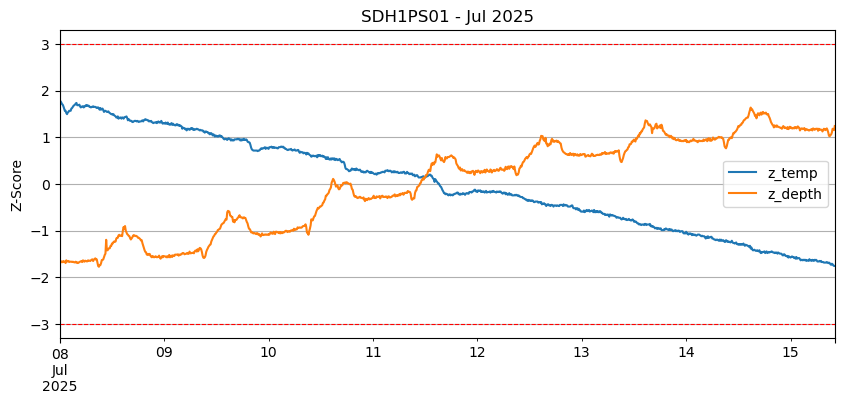


POZO: SDH1PS02
Archivo: SDH1PS02_formatted.csv

Rango de fechas: 2024-11-10 16:00:00 - 2025-07-15 10:00:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35530
0 days 00:20:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 14:00:00   0 days 00:20:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Nov 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-11 12:20:00         14.815   0.6174  5.331948  0.867049
2024-11-11 12:30:00         13.708 

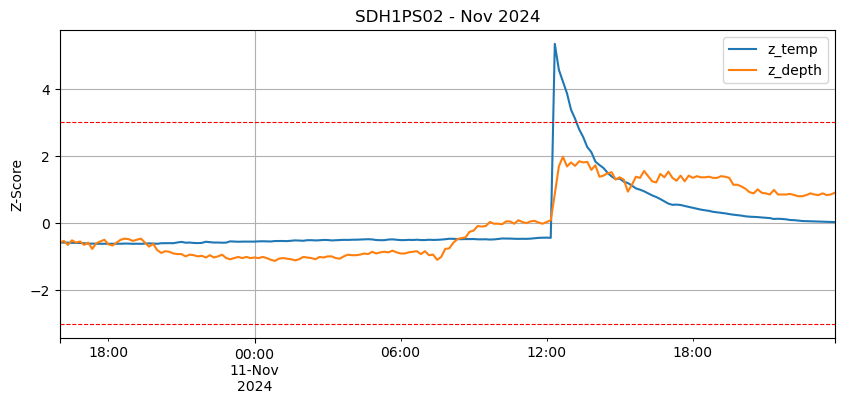


Diagnostico campana de Jan 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 14:00:00         12.384   0.6669  8.706050  1.741444
2025-01-22 14:10:00         12.196   0.6678  4.799593  2.112456
2025-01-22 14:20:00         12.118   0.6661  3.178829  1.411656


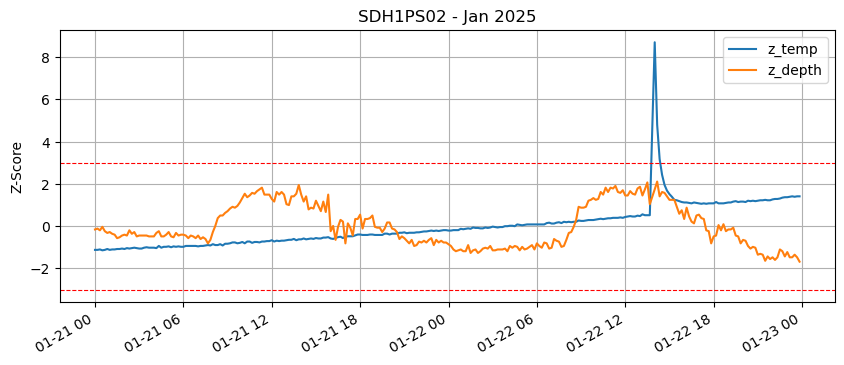


Diagnostico campana de Apr 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-04-30 17:30:00         13.483   0.6758  19.797297  1.616538


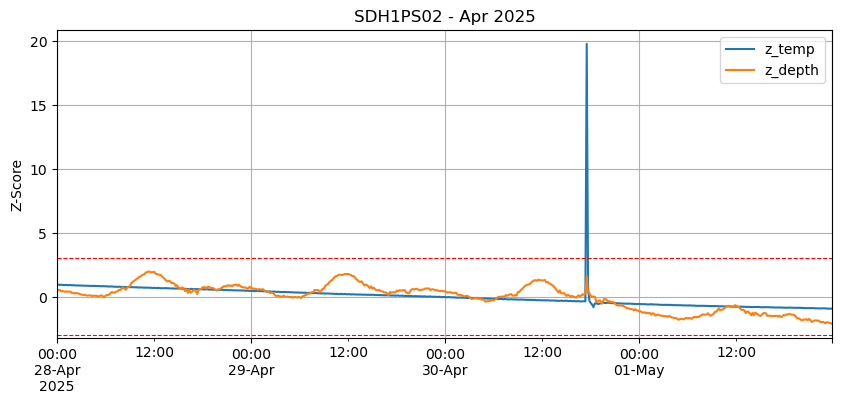


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


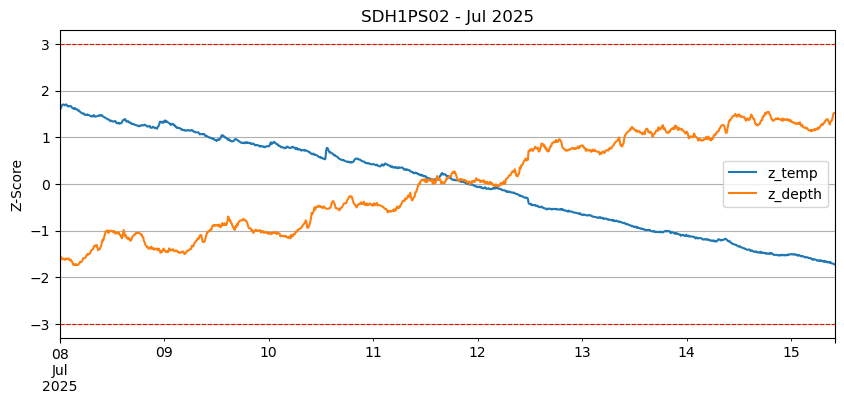


POZO: SDH2PP01
Archivo: SDH2PP01_formatted.csv

Rango de fechas: 2024-05-24 00:00:00 - 2025-04-30 13:10:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    70160
0 days 00:10:00    14089
0 days 02:20:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 17:00:00   0 days 02:20:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-07-25 14:40:00          3.802  -0.1174 -3.277275 -4.455515
2024-07-25 14:45:00          3.805  -0.0420 -3.036646 -1.445991
2024-07-25 14:50:00          3.816  -0.1223 -2.154338 -4.651094
2024-07-25 14:55:00          3.832  -0.1210 -0.870982 -4.599206


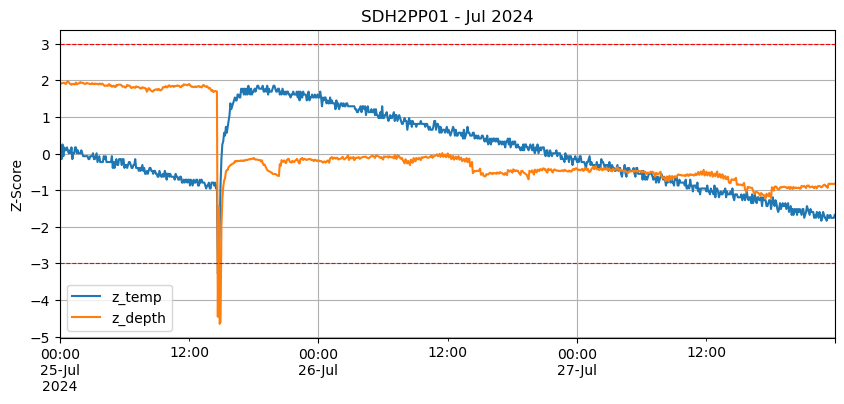


Diagnostico campana de Sep 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


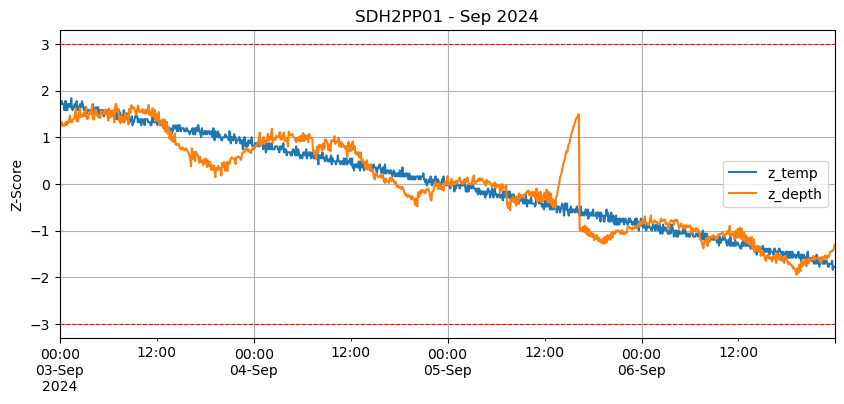


Diagnostico campana de Nov 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-10 12:05:00          2.525  -0.0958 -0.963846 -4.670504
2024-11-10 12:10:00          2.526  -0.0951 -0.882907 -4.597316
2024-11-10 12:15:00          2.525  -0.0948 -0.963846 -4.565950
2024-11-10 12:20:00          2.525  -0.0935 -0.963846 -4.430030
2024-11-10 12:25:00          2.526  -0.0930 -0.882907 -4.377753
2024-11-10 12:30:00          2.525  -0.0932 -0.963846 -4.398664
2024-11-10 12:35:00          2.526  -0.0918 -0.882907 -4.252288
2024-11-10 12:40:00          2.524  -0.0912 -1.044786 -4.189556
2024-11-10 12:45:00          2.525  -0.0905 -0.963846 -4.116368
2024-11-10 12:50:00          2.525  -0.0886 -0.963846 -3.917716
2024-11-10 12:55:00          2.523  -0.0876 -1.125725 -3.813162
2024-11-10 13:00:00          2.526  -0.0867 -0.882907 -3.719063
2024-11-10 13:05:00   

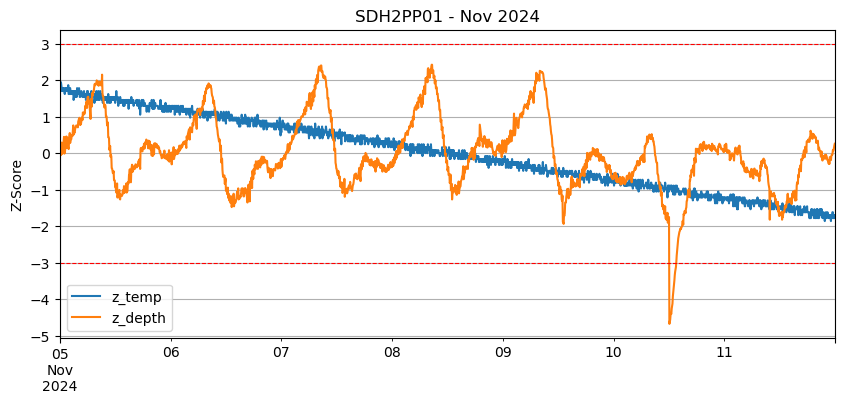


Diagnostico campana de Jan 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 17:00:00          3.610   0.3983  7.493666 -2.403104
2025-01-22 17:10:00          3.579   0.3984  6.029185 -2.390921
2025-01-22 17:20:00          3.556   0.4012  4.942634 -2.049783
2025-01-22 17:30:00          3.541   0.4005  4.234015 -2.135068
2025-01-22 17:40:00          3.531   0.4003  3.761601 -2.159435
2025-01-22 17:50:00          3.521   0.4018  3.289188 -1.976682


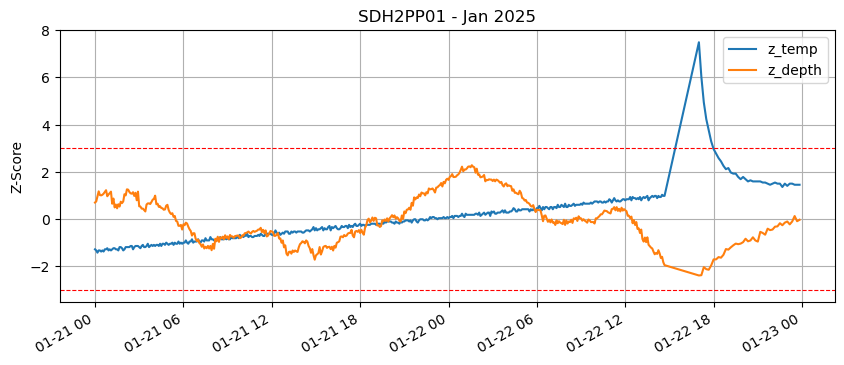


Diagnostico campana de Apr 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp    z_depth
Timestamps                                                       
2025-04-30 13:10:00         21.002   2.1788  19.154981  18.850889


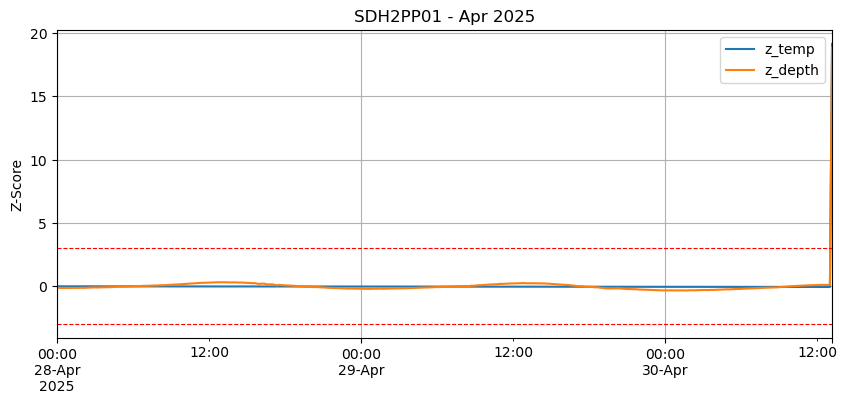


Diagnostico campana de Jul 2025
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH2PS01
Archivo: SDH2PS01_formatted.csv

Rango de fechas: 2024-05-23 00:00:00 - 2024-11-08 16:25:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    48291
1 days 00:05:00        2
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2024-07-26   1 days 00:05:00
2024-09-06   1 days 00:05:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-07-26 00:00:00          1.499   0.1739 -4.188086 -0.077054
2024-07-26 00:05:00          1.501   0.1758 -4.100088  0.104766
2024-07-26 00:10:00          1.506   0.1753 -3.880092

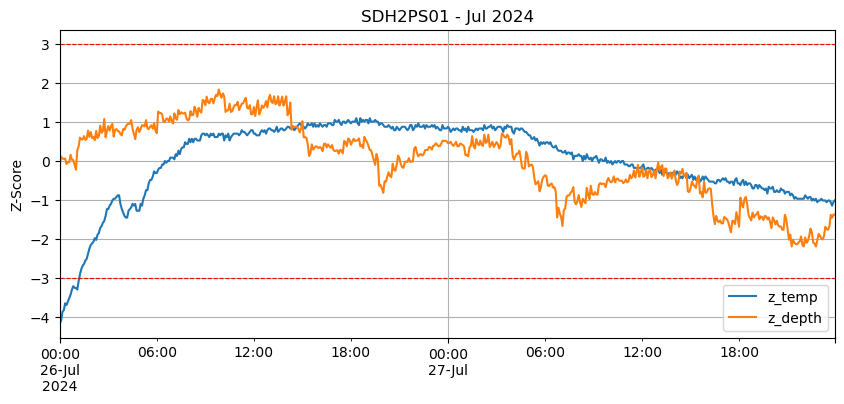


Diagnostico campana de Sep 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


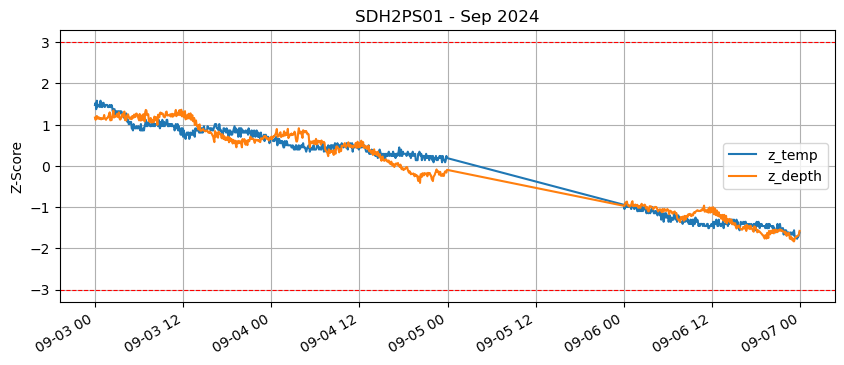


Diagnostico campana de Nov 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2024-11-05 14:50:00          0.640  -0.0422  -4.198298 -0.706509
2024-11-05 14:55:00          0.634  -0.0431  -4.601298 -0.819453
2024-11-05 15:00:00          0.610  -0.0418  -6.213299 -0.656311
2024-11-05 15:05:00          0.608  -0.0454  -6.347632 -1.108087
2024-11-05 15:10:00          0.581  -0.0438  -8.161133 -0.907298
2024-11-05 15:15:00          0.572  -0.0464  -8.765633 -1.233581
2024-11-05 15:20:00          0.556  -0.0464  -9.840300 -1.233581
2024-11-05 15:25:00          0.551  -0.0453 -10.176134 -1.095538
2024-11-05 15:30:00          0.556  -0.0414  -9.840300 -0.606114
2024-11-05 15:35:00          0.565  -0.0391  -9.235800 -0.317479
2024-11-05 15:40:00          0.570  -0.0385  -8.899967 -0.242183
2024-11-05 15:45:00          0.582  -0.0392  -8.093966 -0.330029
2024-11-

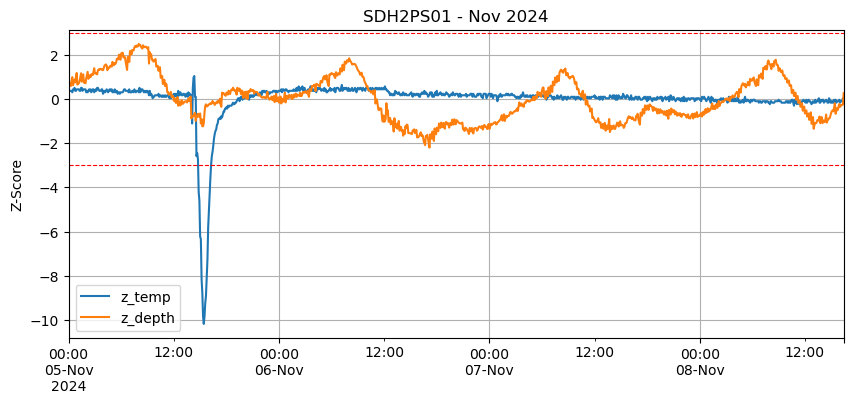


Diagnostico campana de Jan 2025
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Apr 2025
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2025
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH2PS02
Archivo: SDH2PS02_formatted.csv

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:40:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35520
0 days 00:40:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 16:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Di

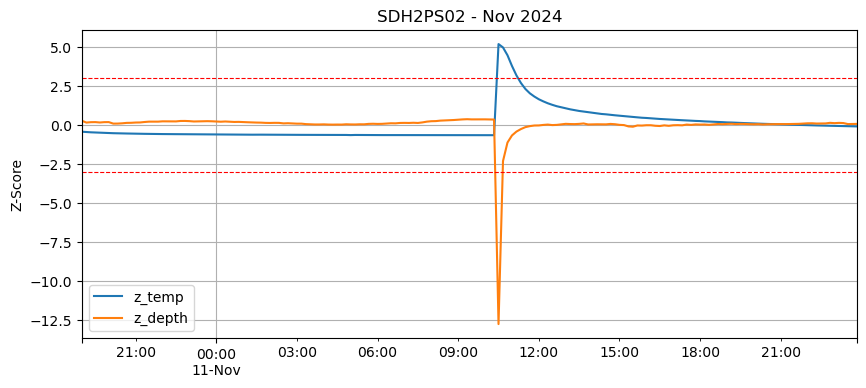


Diagnostico campana de Jan 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-01-22 16:00:00         10.891   1.3563  10.498188  1.729181
2025-01-22 16:10:00         10.766   1.3557   7.071164  1.620909
2025-01-22 16:20:00         10.700   1.3559   5.261696  1.656999
2025-01-22 16:30:00         10.658   1.3556   4.110216  1.602864
2025-01-22 16:40:00         10.628   1.3545   3.287730  1.404366


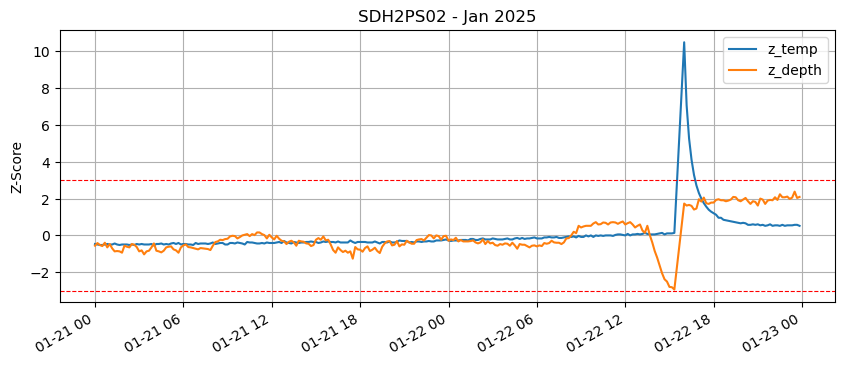


Diagnostico campana de Apr 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-04-30 13:30:00         18.495   1.3715  23.308671  3.841439


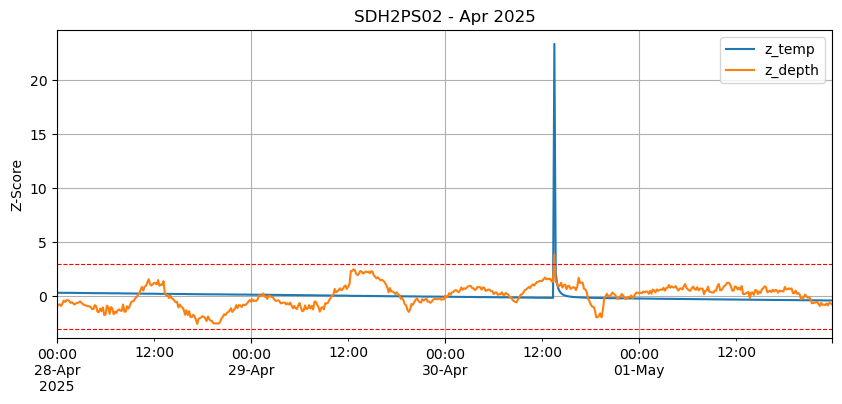


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


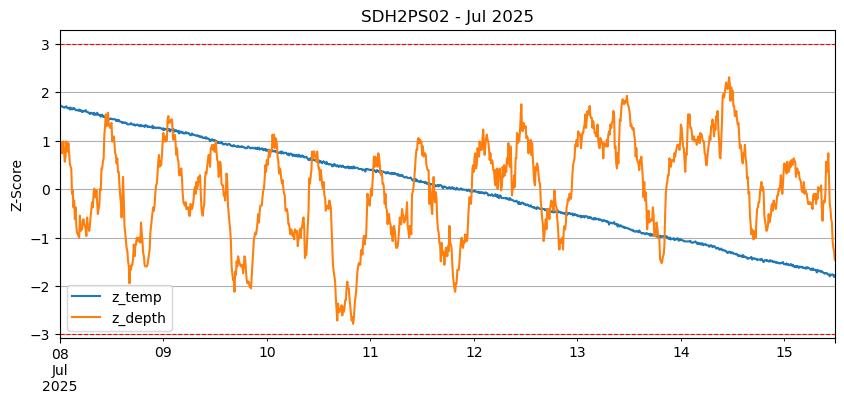


POZO: SDH2PS03
Archivo: SDH2PS03_formatted.csv

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:50:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35522
0 days 00:30:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 16:00:00   0 days 00:30:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Nov 2024
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-11 10:30:00          8.709   0.5677  3.132991 -6.157747
2024-11-11 10:40:00          8.767 

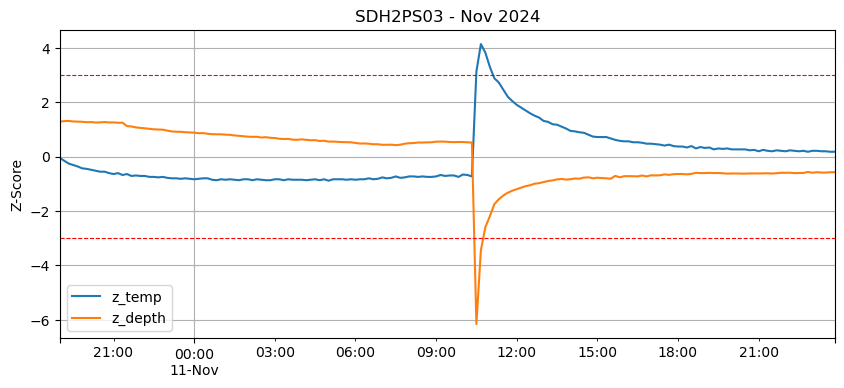


Diagnostico campana de Jan 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-01-22 14:40:00         10.187   0.8874   0.118571 -3.048826
2025-01-22 14:50:00         10.190   0.8863   0.217054 -3.364246
2025-01-22 15:00:00         10.185   0.8842   0.052915 -3.966411
2025-01-22 15:10:00         10.190   0.8844   0.217054 -3.909062
2025-01-22 15:20:00         10.188   0.8835   0.151398 -4.167133
2025-01-22 15:30:00         10.187   0.8825   0.118571 -4.453879
2025-01-22 16:00:00         10.500   0.9021  10.393688  1.166332
2025-01-22 16:10:00         10.390   0.9022   6.782624  1.195007
2025-01-22 16:20:00         10.335   0.9050   4.977092  1.997894
2025-01-22 16:30:00         10.301   0.9013   3.860945  0.936936
2025-01-22 16:40:00         10.280   0.9011   3.171561  0.879587


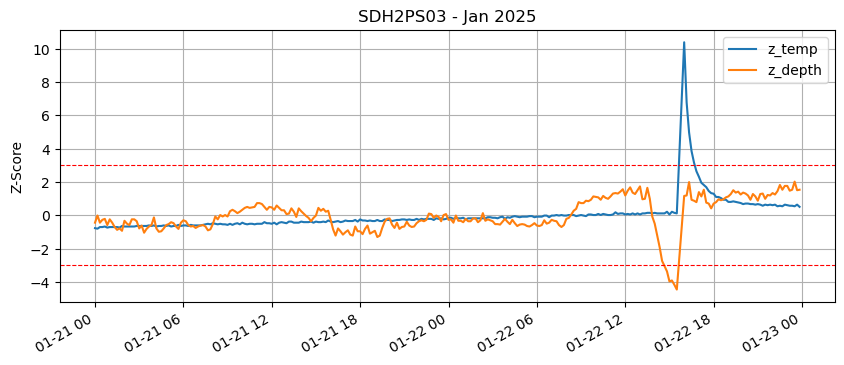


Diagnostico campana de Apr 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-04-30 13:40:00         10.911   0.9066  12.871976  1.154916
2025-04-30 13:50:00         10.323   0.9061   4.779626  0.960721


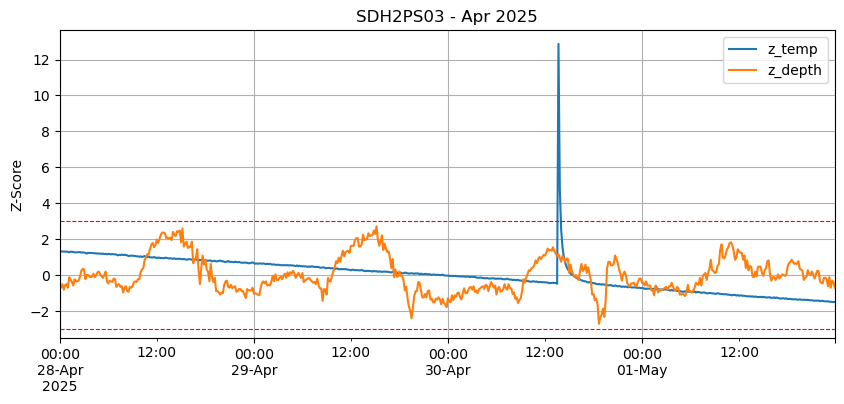


Diagnostico campana de Jul 2025
Identificacion de outliers

Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-07-10 16:00:00          7.080   0.8834  0.384144 -3.075321
2025-07-10 16:10:00          7.079   0.8829  0.368362 -3.235400
2025-07-10 16:20:00          7.080   0.8829  0.384144 -3.235400
2025-07-10 16:30:00          7.081   0.8830  0.399925 -3.203384
2025-07-10 16:40:00          7.083   0.8835  0.431488 -3.043305
2025-07-10 16:50:00          7.086   0.8836  0.478832 -3.011290
2025-07-10 17:00:00          7.086   0.8836  0.478832 -3.011290


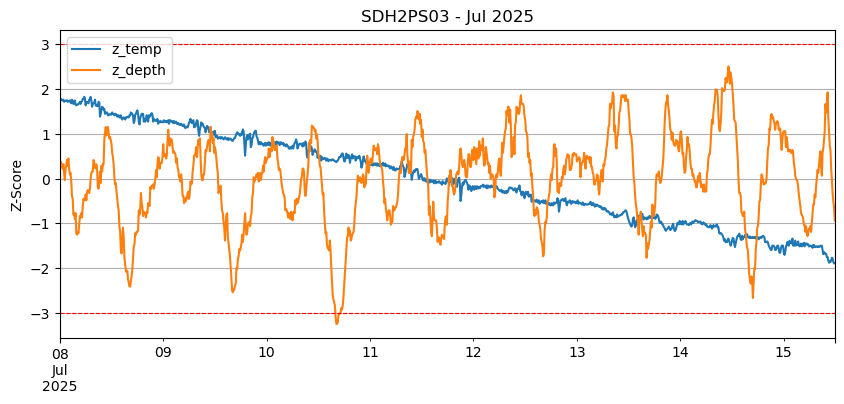

In [8]:
# --- BUCLE DE PROCESAMIENTO ---

# Bucle externo: itera sobre cada pozo
# file_path refiere a cada valor de la lista piezometer_files
for file_path in piezometer_files:
    
    # Define el nombre de cada pozo usando el nombre de archivo.
    # Mantiene la primera cadena de texto, separadas por guion bajo
    base_name = os.path.basename(file_path)
    well_name = base_name.split('_')[0].strip()
    
    # Imprime un titulo que indica el nombre del pozo y de archivo
    print("\n" + "="*80)
    print(f"POZO: {well_name}")
    print(f"Archivo: {os.path.basename(file_path)}")
    print("="*80)
   
   # Lee los datos formateados e imprime el rango de fechas
    df_processed = pd.read_csv(file_path, index_col='Timestamps', parse_dates=True)
    print(f"\nRango de fechas: {df_processed.index.min()} - {df_processed.index.max()}")

    # Aplica las funciones de diagnostico de datos aplicables a todo el archivo
    print("\n--- Diagnostico de datos ---")
    check_duplicates(df_processed)
    check_discontinuities(df_processed, max_expected_interval)

    # Bucle interno: itera sobre las campanas de terreno. 
    # name y dates refieren a los pares de valores almacenados en el diccionario field_campaigns
    for campaing_name, campaign_dates in field_campaigns.items():

        # Imprime el nombre de la campana
        print(f"\nDiagnostico campana de {campaing_name}")

        # Aplica la funcion de identificacion de outliers
        print("Identificacion de outliers")
        check_outliers(df_processed, campaign_dates, well_name, campaing_name)